This notebook uses xgboost to do a multilabel classification of music genre. This workbook uses GTZAN dataset for model training. The dataset consists of the original wav files of the songs,the image data of the songs, and the features data of the songs extracted in csv. In this notebook, we'll use the extracted features to build the model

# Import Libraries and Load Dataset

In [1]:
# Install and update essential libraries and tools
!pip install xgboost -U
!pip install librosa -U
# !apt-get --yes install ffmpeg
!pip install hyperopt

In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,mutual_info_regression
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

#For hyperparameter tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


There are 2 csv files of the features. One has the features for each song for 30 seconds long and another one just has the features of 3 seconds long. The 3-sec dataset contains data of 9990 songs whilst the 30-sec dataset only has 1000 songs (the songs in the genre folder). Looking at the other notebooks, they get a pretty good result making a model from a 3-sec dataset but just an average result for 30-sec dataset. This maybe to the lack of training data.

Despite this, inuitively it is rather difficult to classify a song just by 3 seconds. Making a model from 3 seconds song may affect the real prediction power.
Therefore, we will explore the 30-sec dataset and see what we can do to create a good model

In [3]:
df = pd.read_csv('../input/gtzan-dataset-music-genre-classification/Data/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
df.label.value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [6]:
df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


Initial findings:
1. Only 1000 songs are in the dataset with no null values
2. `length` is not a relevant variable which needs to be dropped in model training phase
3. The data are sorted in the same order as the songs in the folders of the dataset and the classes are balanced
4. There are some other music features that this dataset did not extract, for example, spectral contrast, spectral flatness, tonal centroid features etc. Given it is just a small dataset, we can extract them and put it in the dataframe for further analysis

# Extracting extra features and data cleaning
We will now extract the mean and the variance of `chroma_cens`,`spectral_contrast`, `spectral_flatness` and `tonnetz`

In [7]:
songs_path = '../input/gtzan-dataset-music-genre-classification/Data/genres_original'

def extract_new_features(song_path, num_files = 1000, num_new_features = 8):

    data_array = np.empty([num_files, num_new_features])

    counter = 0
    for root, dirs, files in os.walk(songs_path):
        dirs.sort()
        for file, i in zip(sorted(files), tqdm(range(num_files))):
            i = i + (counter-1)*100
            file_path = os.path.join(root, file)
        
            try:
                #extract mean and variance of those 4 features
                y, sr = librosa.load(os.fspath(file_path))
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                spectral_flatness = librosa.feature.spectral_flatness(y=y)
                tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

                data_array[i,0] = np.mean(chroma_cens)
                data_array[i,1] = np.var(chroma_cens)
                data_array[i,2] = np.mean(spectral_contrast)
                data_array[i,3] = np.var(spectral_contrast)
                data_array[i,4] = np.mean(spectral_flatness)
                data_array[i,5] = np.var(spectral_flatness)
                data_array[i,6] = np.mean(tonnetz)
                data_array[i,7] = np.var(tonnetz)
                
            # Set all values to zero for files with problems
            except:
                print(f'Problem file: {file_path}')
                for j in range(num_new_features):
                    data_array[i, j] = 0 
                
        counter += 1
                  
    return data_array


new_features_array = extract_new_features('../input/gtzan-dataset-music-genre-classification/Data/genres_original')

  6%|▌         | 55/1000 [01:18<18:03,  1.15s/it]

Problem file: ../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav


 10%|▉         | 99/1000 [02:25<22:04,  1.47s/it]


We can see that in the dataset, `jazz.00054.wav` this file has a problem and can't be played. We will initialize the values to 0 and will do further treatment after.

In [8]:
#Add those new features back to the original dataframe

df['chroma_cens_mean'] = new_features_array[:,0]
df['chroma_cens_var'] = new_features_array[:,1]
df['spectral_contrast_mean'] = new_features_array[:,2]
df['spectral_contrast_var'] = new_features_array[:,3]
df['spectral_flatness_mean'] = new_features_array[:,4]
df['spectral_flatness_var'] = new_features_array[:,5]
df['tonnetz_mean'] = new_features_array[:,6]
df['tonnetz_var'] = new_features_array[:,7]

Since there is only 1 row of missing value, now we'll just fill in the missing values of `jazz.0054.wav` as the mean of those of the jazz songs, which is at index 554

In [9]:
for i in range(-8,0,1):
    # Filter out the jazz genre except jazz.0054
    df.iloc[554,i] = df[ df.label == 'jazz'].iloc[np.r_[np.arange(0,54),np.arange(55,100)],i].mean()

In [10]:
# Save as a new csv
df.to_csv('new_csv',index=False)

In [11]:
#Exclude filename and Length
df = df.iloc[:,2:]

# EDA and Data preprocessing

**Correlations between mean variables**

<AxesSubplot:>

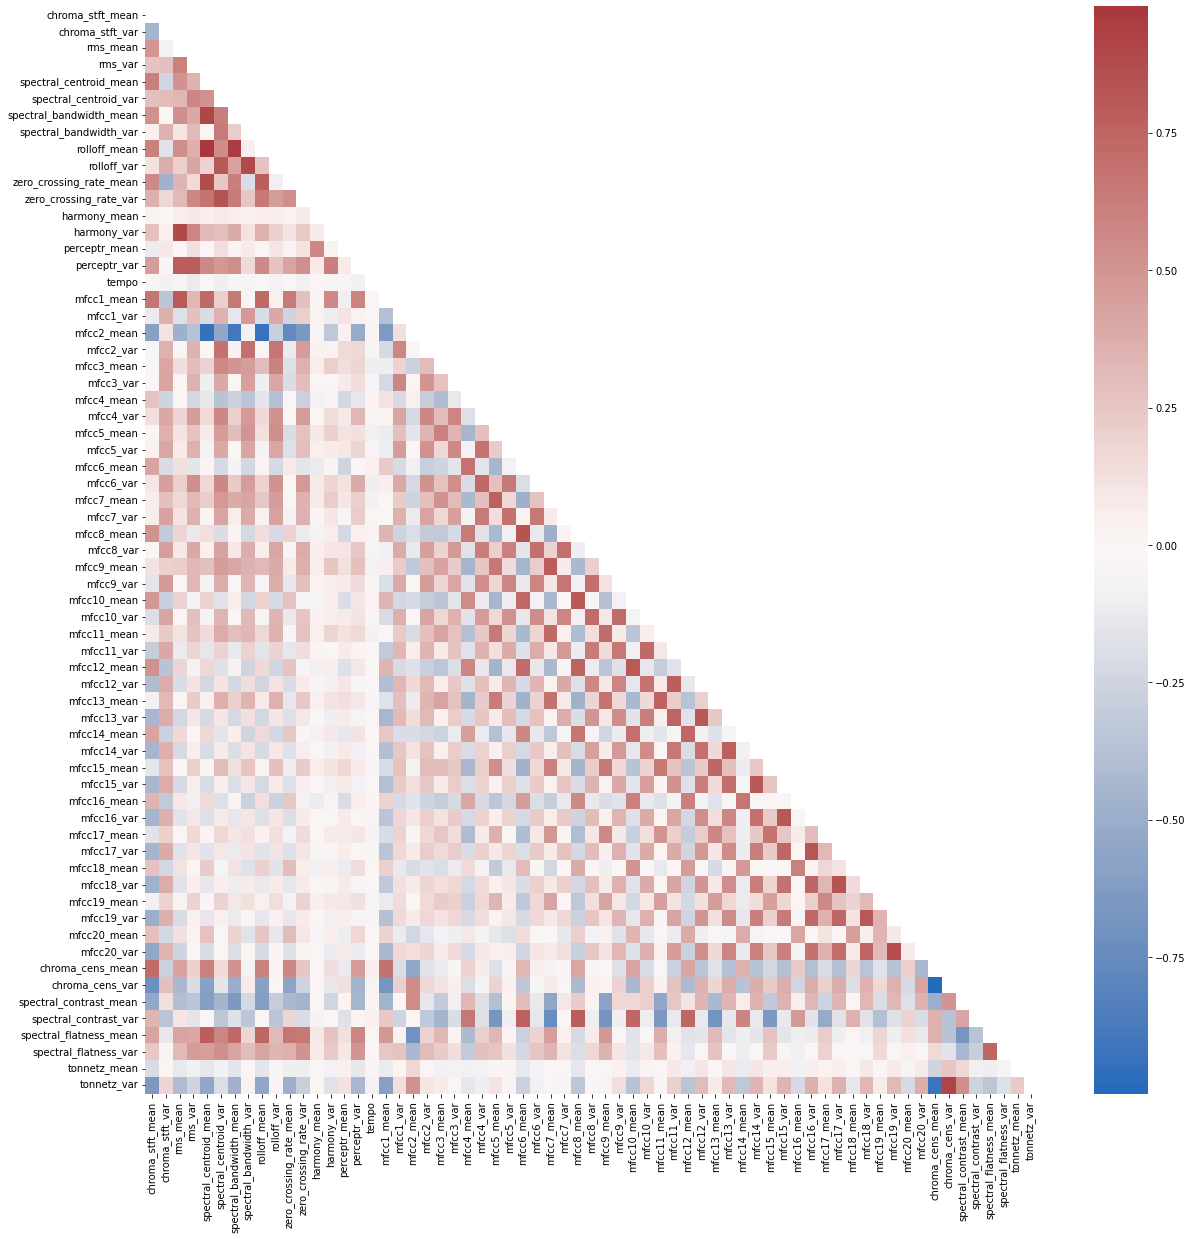

In [12]:
corr = df.corr()

#Create a mask for the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap="vlag")


Most of the variables do not have a high correlation with other variables. Let's filter out the extremely highly correlated pairs and examine them.

In [13]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
for index, value in sol.items():
    if (value > 0.75) or (value < -0.75):
        print(index, value)

('spectral_centroid_mean', 'rolloff_mean') 0.9796372839713294
('spectral_bandwidth_mean', 'rolloff_mean') 0.9561890507384935
('chroma_cens_var', 'tonnetz_var') 0.9120508021375788
('spectral_centroid_mean', 'spectral_bandwidth_mean') 0.9044346071495829
('rms_mean', 'harmony_var') 0.8938978949769321
('spectral_bandwidth_var', 'rolloff_var') 0.8848769664091609
('spectral_centroid_mean', 'zero_crossing_rate_mean') 0.8747491925002655
('mfcc19_var', 'mfcc20_var') 0.8687180893195621
('spectral_centroid_var', 'zero_crossing_rate_var') 0.8441413391352148
('mfcc6_mean', 'mfcc8_mean') 0.8373116484632848
('mfcc17_var', 'mfcc18_var') 0.8331488323994957
('mfcc16_var', 'mfcc17_var') 0.8273181486552698
('mfcc18_var', 'mfcc19_var') 0.8209858681502503
('mfcc15_var', 'mfcc16_var') 0.8208510961351836
('spectral_centroid_var', 'rolloff_var') 0.8155497715224753
('mfcc12_var', 'mfcc13_var') 0.8120478485875313
('mfcc8_mean', 'mfcc10_mean') 0.8118547065473206
('mfcc14_var', 'mfcc15_var') 0.810825439588405
('mf

**Split to train data and test data**

Given the small number of training data, I set 90% as training data and 10% as testing data. For hyparameter tuning, given the small dataset, we will use the same train dataset to tune
For the split of data, I make sure every class has the same number of data to train and test.

In [14]:
y = df.label
X = df

#Use `label` to split data evenly and drop `label` column after split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=df.label, random_state=77)
X_train.drop('label',axis=1,inplace=True)
X_test.drop('label',axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Normalize the data**

In [15]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = sc.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Initial model fitting and recursive feature elimination
Now we will fit our training data to xgboost classifier first, and then we'll do RFECV to check which variables can be eliminated

In [16]:
estimator = XGBClassifier(eval_metric='merror')
rfecv = RFECV(estimator, step=1, cv=5,scoring='accuracy',verbose=1)
rfecv.fit(X_train, y_train)

Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

RFECV(cv=5,
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              eval_metric='merror', gamma=None, gpu_id=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None),

In [17]:
# See which features can be eliminated
features_drop_array = list(np.where(rfecv.support_ == False)[0])
X_train.columns[features_drop_array]

Index(['mfcc6_mean', 'mfcc9_var', 'mfcc11_var', 'mfcc14_var', 'mfcc16_mean',
       'mfcc16_var', 'mfcc17_var', 'mfcc19_mean', 'chroma_cens_var'],
      dtype='object')

In [18]:
X_train.drop(X_train.columns[features_drop_array], axis=1, inplace=True)
X_test.drop(X_test.columns[features_drop_array], axis=1, inplace=True)

# Model training

We will just use XGBoost Classifier to classify

In [19]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [20]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

Training accuracy: 0.9988888888888889
Training:
               precision    recall  f1-score   support

       blues       1.00      1.00      1.00        90
   classical       1.00      1.00      1.00        90
     country       1.00      1.00      1.00        90
       disco       1.00      1.00      1.00        90
      hiphop       1.00      1.00      1.00        90
        jazz       1.00      1.00      1.00        90
       metal       0.99      1.00      0.99        90
         pop       1.00      1.00      1.00        90
      reggae       1.00      1.00      1.00        90
        rock       1.00      0.99      0.99        90

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900

Testing accuracy: 0.78
Testing:
               precision    recall  f1-score   support

       blues       0.75      0.90      0.82        10
   classical       0.90      0.90      0.90       

<AxesSubplot:>

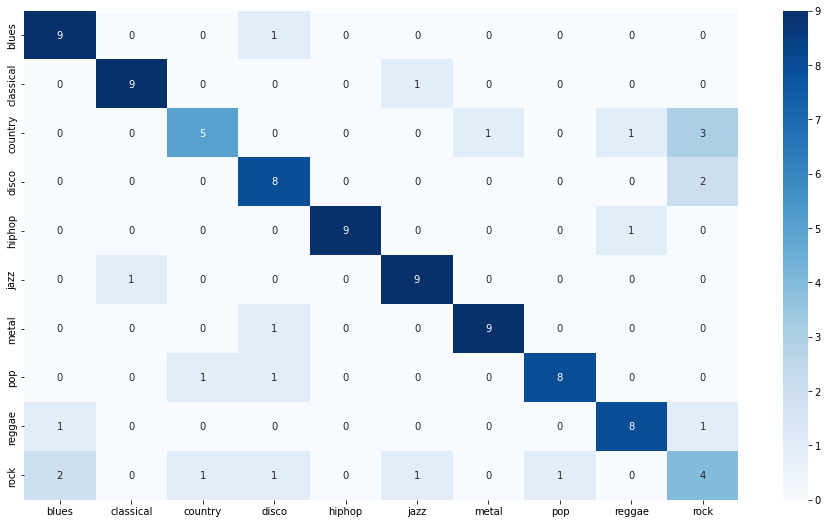

In [21]:
#Confusion matrix of the test data
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (16, 9))
sns.heatmap(cm,cmap="Blues", annot=True, xticklabels = target_names, yticklabels = target_names )

We may see that we have got 99% of accuracy for training data, but just 78% for the testing data. Obviously, we are overfitting our model. In the following, we will add regularization parameters and tune other parameters to reduce this problem.

# Hyperparameter tuning
In the following, we'll use `hyperopt` library to help tuning the parameters. The parameters may vary for each run

In [22]:
space={
    'n_estimators': hp.quniform('n_estimators', 0,3000,1),
    'reg_lambda' : hp.quniform('reg_lambda', 0,500,1),
    }

def objective(space):
    clf=XGBClassifier(
                    n_estimators =int(space['n_estimators']),
                    reg_lambda = int(space['reg_lambda']),
                    )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [13:33<00:00,  8.14s/trial, best loss: -0.83]


In [23]:
print(f"best params: {best_hyperparams}")

best params: {'n_estimators': 1639.0, 'reg_lambda': 12.0}


In [24]:
model1 = XGBClassifier(n_estimators=304, reg_lambda=25)
model1.fit(X_train,y_train,eval_metric='merror')
y_pred_test1 = model1.predict(X_test)
print(f"accuracy: {accuracy_score(y_test,y_pred_test1)}")
print(f'New tuned model:\n {classification_report(y_test, y_pred_test1, labels=target_names)}')


accuracy: 0.81
New tuned model:
               precision    recall  f1-score   support

       blues       0.83      1.00      0.91        10
   classical       0.90      0.90      0.90        10
     country       0.71      0.50      0.59        10
       disco       0.80      0.80      0.80        10
      hiphop       1.00      0.80      0.89        10
        jazz       0.82      0.90      0.86        10
       metal       0.83      1.00      0.91        10
         pop       0.89      0.80      0.84        10
      reggae       0.80      0.80      0.80        10
        rock       0.55      0.60      0.57        10

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



Our accuracy, precision and recall both improved a little bit from 78% to 81%. We will make this our final model

# Save the model and the preprocessing

In [25]:
pickle.dump(sc, open('sc.pkl','wb'))
pickle.dump(model1, open('model.pkl', 'wb'))